In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import joblib

%matplotlib inline
plt.rcParams["figure.figsize"] = (12,9)

In [18]:
df = pd.read_csv('data/sleepdata.csv', sep=';', parse_dates=['Start', 'End'])
df['Start time'] = pd.Series([val.time() for val in df['Start']])
df['End time'] = pd.Series([val.time() for val in df['End']])
df['Start time in second'] = df['Start time'].apply(lambda x: (x.hour*60+x.minute)*60 + x.second)
df['End time in second'] = df['End time'].apply(lambda x: (x.hour*60+x.minute)*60 + x.second)
df['Time in bed'] = df['End'] - df['Start']
df['Time in bed'] = df['Time in bed'].astype('timedelta64[s]') # in seconds
# convert sleep quality to float:
df['Sleep quality'] = df['Sleep quality'].apply(lambda x: np.nan if x in ['-'] else x[:-1]).astype(int)
df['Wake up'] = df['Wake up'].replace({':)':2, ':|':1, ':(':0})
df.head()

,Start,End,Sleep quality,Time in bed,Wake up,Sleep Notes,Heart rate,Activity (steps),Start time,End time,Start time in second,End time in second
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100,30744.0,2.0,NaN,59.0,0,22:57:49,07:30:13,82669,27013
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3,964.0,1.0,Stressful day,72.0,0,21:17:50,21:33:54,76670,77634
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98,30642.0,1.0,NaN,57.0,0,22:42:49,07:13:31,81769,26011
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65,27120.0,NaN,NaN,NaN,0,22:31:01,06:03:01,81061,21781
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72,24265.0,2.0,Drank coffee:Drank tea,68.0,0,22:12:10,04:56:35,79930,17795


In [19]:
df['External_fact']=0
df.loc[~df['Sleep Notes'].isna(), 'External_fact' ]=1

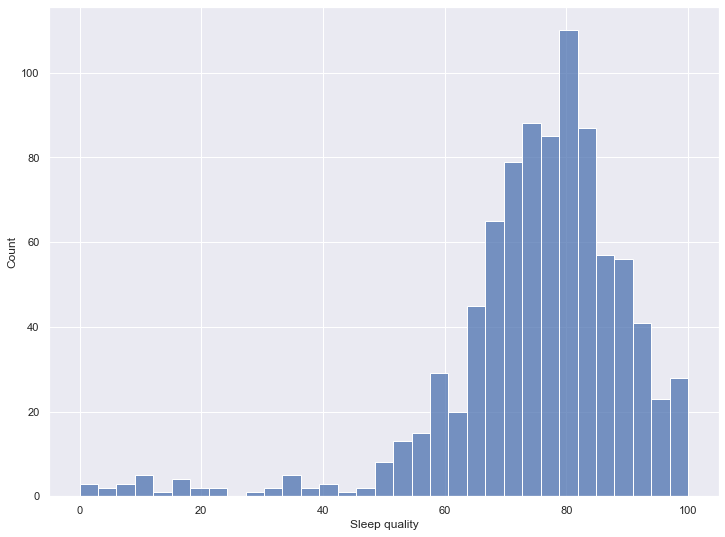

In [22]:
sns.set_theme()
plot = sns.histplot(df, x='Sleep quality')
# plot.set_title('Sleep quality distribution')

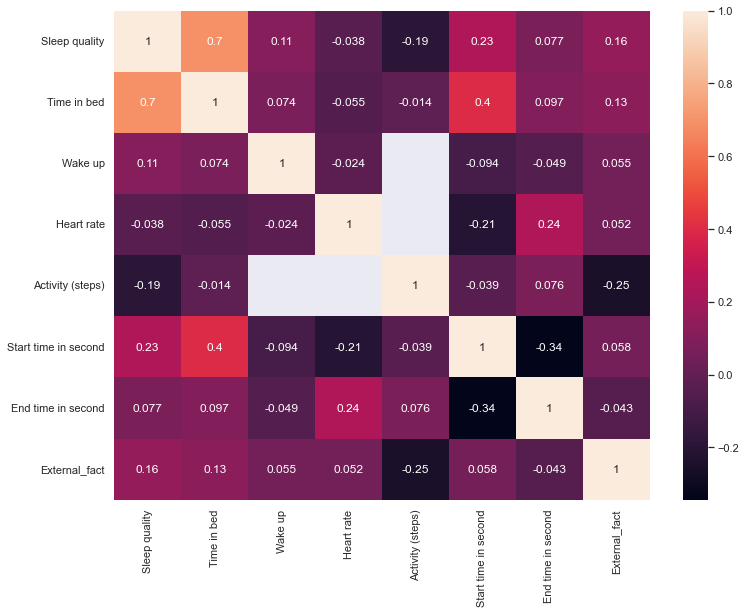

In [26]:
plot = sns.heatmap(df.corr(), annot=True)

In [27]:
df.dropna(inplace=True)
# X = df[['Time in bed', 'Start time in second','End time in second','Activity (steps)', 'Wake up']].values
X = df[['Time in bed', 'Start time in second','End time in second','Activity (steps)','External_fact']].values
y = df['Sleep quality'].values

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# scaler = MinMaxScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

In [29]:
from sklearn.linear_model import LinearRegression
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.1634650872686324

In [30]:
y_pred = rf.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

9.947342974788016

In [31]:
filename = 'finalized_model.joblib'
joblib.dump(rf, filename)
 
# some time later...
 
# load the model from disk
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, y_test)
print(result)

0.1634650872686324


In [63]:
X_test[0]

array([2.8899e+04, 8.0237e+04, 2.2736e+04, 0.0000e+00, 1.0000e+00])

In [64]:
loaded_model.predict(X_test[25].reshape(1, -1))

array([72.63])

In [65]:
X = np.array([964.0,82669,27013,1000,0]).reshape(1,-1)
loaded_model.predict(X)

array([45.89])

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

In [38]:
rf = RandomForestRegressor()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [39]:
n_estimators = range(1,200,2)
max_depth= range(1,100,1)
min_samples_split=range(2,10,1)
min_samples_leaf=range(1,10,1)
grid = dict(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

In [47]:
n_estimators = range(50,200,10)
max_depth= range(1,40,5)
min_samples_split=range(2,10,2)
min_samples_leaf=range(1,10,2)
grid = dict(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

In [48]:
print("[INFO] grid searching over the hyperparameters...")
cvFold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
gridSearch = GridSearchCV(estimator=rf, param_grid=grid, n_jobs=-1,
	cv=cvFold, scoring="neg_mean_squared_error")
searchResults = gridSearch.fit(X_train, y_train)
# extract the best model and evaluate it
print("[INFO] evaluating...")
bestModel = searchResults.best_estimator_
print("R2: {:.2f}".format(bestModel.score(X_test, y_test)))

[INFO] grid searching over the hyperparameters...


KeyboardInterrupt: 

In [50]:
from scipy.stats import uniform, geom, loguniform, randint, expon
from sklearn.model_selection import RandomizedSearchCV

In [69]:
import warnings
warnings.simplefilter("ignore")
rf = RandomForestRegressor()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

N_ITER = 54
N_JOBS = 1
K_FOLDS = 10
N_ITER_NO_CHANGE = 100
RANDOM_STATE = 10
SCORING_METRIC = 'neg_root_mean_squared_error'

hyper_parameters = {
        'n_estimators': randint(50,500),
        'max_depth': randint(3,10),
        'min_samples_split': randint(2,20),
        'random_state': [RANDOM_STATE],
        'min_samples_leaf': randint(1,10)
}

search_space = RandomizedSearchCV(
    rf, hyper_parameters, 
    n_iter = N_ITER, cv=K_FOLDS,
    scoring=SCORING_METRIC, n_jobs = N_JOBS, 
    return_train_score=True, verbose = 1
)
search_space.fit(X_train, y_train) 

y_pred = search_space.best_estimator_.predict(X_train)
y_pred_prob = search_space.best_estimator_.predict(X_train)
y_pred_test = search_space.best_estimator_.predict(X_test)

print( 
    'Best Training Score: ', search_space.cv_results_['mean_train_score'][search_space.best_index_], 
    '\nBest Test Score: ', search_space.best_score_,
)

Fitting 10 folds for each of 54 candidates, totalling 540 fits
Best Training Score:  -9.792779071644063 
Best Test Score:  -11.352146291681077


In [74]:
df = pd.DataFrame(search_space.cv_results_)

<AxesSubplot:xlabel='param_n_estimators', ylabel='mean_train_score'>

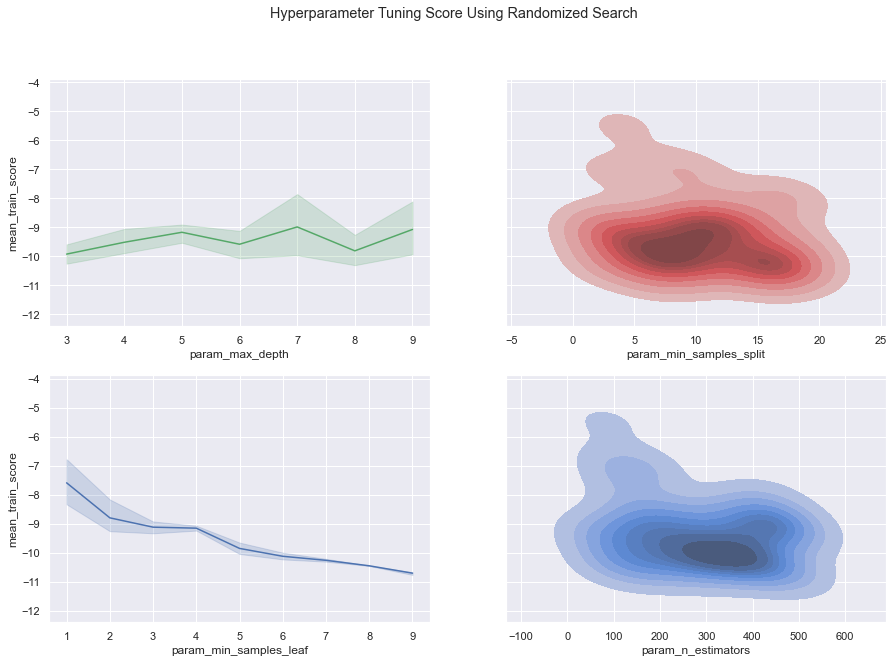

In [133]:
# relplot lineplot
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=True)
fig.suptitle('Hyperparameter Tuning Score Using Randomized Search')

sns.lineplot(data = df, x='param_max_depth', y='mean_train_score', color='g',
             ax=axes[0][0])

sns.kdeplot(data = df, x='param_min_samples_split', y='mean_train_score', shade=True, color='r',
             ax=axes[0][1])

sns.lineplot(data = df, x='param_min_samples_leaf', y='mean_train_score', 
            # shade=True, color='r',
             ax=axes[1][0])

sns.kdeplot(
    data=df,
    x="param_n_estimators", y="mean_train_score", shade=True)

In [76]:
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_random_state,params,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.189177,0.022660,0.012713,0.004711,5,3,10,197,10,"{'max_depth': 5, 'min_samples_leaf': 3, 'min_s...",...,-8.034511,-9.245317,-9.127576,-9.407423,-9.443713,-8.972110,-9.095934,-9.123771,-9.024062,0.391743
1,0.077084,0.006226,0.006440,0.003220,9,1,4,85,10,"{'max_depth': 9, 'min_samples_leaf': 1, 'min_s...",...,-5.638956,-5.720335,-5.370543,-5.612643,-5.709625,-5.315267,-5.555200,-5.292757,-5.510352,0.193812
2,0.138915,0.007528,0.010403,0.003636,5,2,15,165,10,"{'max_depth': 5, 'min_samples_leaf': 2, 'min_s...",...,-8.284227,-9.145604,-8.986355,-9.402751,-9.377696,-8.941675,-8.986207,-8.912949,-8.988665,0.309097
3,0.078404,0.004793,0.007192,0.002398,9,5,6,90,10,"{'max_depth': 9, 'min_samples_leaf': 5, 'min_s...",...,-8.350505,-9.653536,-9.660248,-9.904879,-9.795737,-9.534275,-9.555915,-9.634068,-9.512043,0.415546
4,0.114833,0.005846,0.008801,0.002400,8,6,17,136,10,"{'max_depth': 8, 'min_samples_leaf': 6, 'min_s...",...,-8.966928,-10.359879,-10.330310,-10.563408,-10.450871,-10.118742,-10.156878,-10.163412,-10.140347,0.422151


In [67]:
search_space.best_estimator_

RandomForestRegressor(max_depth=3, max_features='sqrt', min_samples_split=7,
                      n_estimators=204, random_state=10)

In [ ]:
search_space.best_score_

In [ ]:
search_space.param_distributions

In [66]:
import matplotlib.pyplot as plt
from skopt.plots import plot_objective, plot_histogram

_ = plot_objective(search_space.optimizer_results_[0],
                   n_minimum_search=int(1e8))
plt.show()

AttributeError: 'RandomizedSearchCV' object has no attribute 'optimizer_results_'